# I presented and arranged the data in 2 ways that gave me different results and finally, I chose the ____ way:
* ### The 'df'  -  I initially tried to display the data in the form of a long vector, with each vector (row) containing 5 frames, with the frames selected every second in skips of 5 frames at a time.
* ### The 'one_frame_df'  -   After many attempts, I thought of trying to present the data in a 'simpler' way so that each row has only one frame (with right hand versus left hand, of course), this way each row contains much fewer 'features' and thus the model is simpler.

In [443]:
import numpy as np
import pandas as pd 
import os
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.dummy import DummyClassifier



In [12]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m' 

In [62]:
base_dir = r'C:\Users\Aviva\Desktop\extraFiles'
train_dir = os.path.join(base_dir, "Training")
test_dir = os.path.join(base_dir, "Validation")
names = os.listdir(train_dir)
names_test = os.listdir(test_dir)
df_handRight = pd.read_csv(r'C:\Users\Aviva\Desktop\HandRight.csv')
classes = ['Alone', 'Spontan', 'Sync']

In [31]:
# def creat_df (df_temp, state):
# #     df_one = pd.DataFrame # just temporary! 
# #     df_final = pd.DataFrame
#     first=True
#     start =  int(df_temp['Time_L'][0])
#     end = int(df_temp['Time_L'][df_temp.index.max()])
#     for time in range(start, end):
#         df_sec = df_temp[df_temp['Time_L'] == time]
#         df_sec = df_sec.iloc[::5, :] # choose rows, each 5 rows from the second
#         df_sec = df_sec.reset_index(drop=True)
#         if len(df_sec.index) >= 5:
#             for frame in range(0,5): 
#                 df_frame = df_sec[df_sec.index == frame]
#                 for column in  df_frame.columns:  # change the columns names
#                     column_new = column+"_{}".format(str(frame))
#                     df_frame.columns = df_frame.columns.str.replace(column, column_new) 
#                 #---merge all frames to one row----
#                 df_frame = df_frame.reset_index(drop=True)
#                 if frame == 0:
#                     df_one = df_frame
#                 else:
#                     df_one = pd.concat([df_one, df_frame], axis=1, join="inner")
#             df_one['state'] = state
#             if first:
#                 df_final = df_one
#                 first = False
#             else:
#                 df_final = pd.concat([df_final,df_one])                
#     return df_final


In [78]:
 def creat_df (df_temp, state):
    first=True
    start =  int(df_temp['Time_L'][0])
    end = int(df_temp['Time_L'][df_temp.index.max()])
    for time in range(start, end):
        df_sec = df_temp[df_temp['Time_L'] == time]
        df_sec = df_sec.iloc[::5, :] # choose rows, each 5 rows from the second
        df_sec = df_sec.reset_index(drop=True)
        while len(df_sec.index) >= 5:
            df_senple = df_sec.iloc[:5, :]    # choose the first 5 rows
            df_senple = df_senple.reset_index(drop=True)
            for frame in range(0,5): 
                df_frame = df_senple[df_senple.index == frame]
                for column in  df_frame.columns:  # change the columns names
                    column_new = column+"_{}".format(str(frame))
                    df_frame.columns = df_frame.columns.str.replace(column, column_new) 
                #---merge all frames to one row----
                df_frame = df_frame.reset_index(drop=True)
                if frame == 0:
                    df_one = df_frame
                else:
                    df_one = pd.concat([df_one, df_frame], axis=1, join="inner")
            df_one['state'] = state
            if first:
                df_final = df_one
                first = False
            else:
                df_final = pd.concat([df_final,df_one])
            df_sec = df_sec.iloc[5:, :]   # delete the first 5 rows

    return df_final

In [79]:
# Function to duplicate rows
def duplicate_rows(df):
    df2 = pd.read_csv(r'C:\Users\Aviva\Desktop\HandRight.csv')
    for column in df2.columns:  # change the columns names
                column_new = column+'_R'
                df2.columns = df2.columns.str.replace(column, column_new)
    df = pd.concat([df,df2])
    df = df.reset_index(drop=True)
    return df

In [80]:
def clean_csv (df_temp, state):
    start = df_temp['Time_L'][0] + 7
    df_temp = df_temp[df_temp['Time_L'] > start] # clean the first 7 secends
    if state != '1':
        df_temp = df_temp[df_temp[' # hands_L'] == 2] # clean all the rows with 1 hands if not 'alone' state
        df_temp = df_temp[df_temp[' # hands_R'] == 2] # clean all the rows with 1 hands if not 'alone' state
        df_temp = df_temp.drop(columns=[' # hands_R', ' # hands_L',
                                        ' Hand Type_R', ' Hand Type_L']) # remove irrelevant column
    else:
        df_temp = df_temp.drop(columns=[' # hands_L',
                                        ' Hand Type_L',
                                       ' Frame ID']) # remove irrelevant column
    df_temp['Time_L'] = df_temp['Time_L'].apply(np.floor) #round the time columns so it will be easier to work with
    df_temp = df_temp.reset_index(drop=True)
    return df_temp

In [125]:
def secend_clean (df):
    df = df.drop(columns=[
                          ' # hands_R_4', ' Hand Type_R_4',
                          ' # hands_R_3', ' Hand Type_R_3',
                          ' # hands_R_2', ' Hand Type_R_2',
                          ' # hands_R_1', ' Hand Type_R_1',
                          ' # hands_R_0', ' Hand Type_R_0',
                           'Time_R_4',
                           'Time_L_4',
                           'Time_R_3',
                           'Time_L_3',
                           'Time_R_2',
                           'Time_L_2',
                           'Time_R_1',
                           'Time_L_1',
                           'Time_R_0',
                           'Time_L_0'
    ]) # remove irrelevant column
    df = df.reset_index(drop=True)
    return df

# state:
* ## Alone = '1'
* ## Spontan = '2'
* ## Sync = '3'

In [82]:
def Loading_dataset (person_path):
    first = True
    df_final = pd.DataFrame
    csv_files = os.listdir(person_path)
    if len(csv_files) == 4:
        csv_files.remove('garbage') #remove 'garbage' file from list
    for csv in csv_files:
#         print ('------------------------------------------------------',csv,'-------------------------------------------------------------')
        df_temp = pd.read_csv(os.path.join(person_path, csv))
        state = csv.split('.')[0][-1]
        if state == 'e':
            state = '1'
        elif state == 'n':
            state = '2'
        else:
            state= '3'
#         df_temp = df_temp.dropna() # Drop the rows where at least one element is missing.
        #---right dataframe-----
        if state == '1': # state=alone
            df_right = pd.read_csv(r'C:\Users\Aviva\Desktop\HandRight.csv')
            for column in df_right.columns:  # change the columns names
                if column != ' Frame ID':
                    column_new = column+'_R'
                    df_right.columns = df_right.columns.str.replace(column, column_new)
        else:
            df_right = df_temp[df_temp[' Hand Type'] == 'right']
            df_right = df_right.reset_index(drop=True)
            for column in df_right.columns:  # change the columns names
                if column != ' Frame ID':
                    column_new = column+'_R'
                    df_right.columns = df_right.columns.str.replace(column, column_new)


        #---left dataframe-----
        df_left = df_temp[df_temp[' Hand Type'] == 'left'] 
        df_left = df_left.reset_index(drop=True)
        for column in df_left.columns:  # change the columns names
            if column != ' Frame ID':
                column_new = column+'_L'
                df_left.columns = df_left.columns.str.replace(column, column_new)
        
        #---merge the left and the right hands----
        if len(df_right.index) < len(df_left.index) and state=='1': 
#             if state=='1': # only if state = alone
            df_right = duplicate_rows(df_right)  # duplicate rows of 'df_right'
        if state != '1':
            df_right.set_index(' Frame ID',inplace=True)
            df_left.set_index(' Frame ID',inplace=True)
            df_temp = pd.merge(df_left, df_right, how='left',on=' Frame ID')
#             df_temp = pd.concat([df_left, df_right], axis=1, join="inner")
        else:
            df_temp = pd.concat([df_left, df_right], axis=1, join="inner")#, ignore_index=True)
#--------------------------try---------------------------------------------------------
        df_temp = df_temp.dropna() # Drop the rows where at least one element is missing.
        df_temp = df_temp.reset_index(drop=True)
        df_temp = clean_csv(df_temp, state)
#         df_temp = df_temp.reset_index(drop=True)
        df_temp = creat_df(df_temp, state)  # Arranges the data in a 'limited way'
        if first:
            df_final = df_temp
            first = False
        else:
            df_final = pd.concat([df_final,df_temp])
    df_final = secend_clean(df_final)
    return df_final

# Data with a long row:
* ### I arranged the data here in this way, every second - every 5 frames I selected a frame and then assembled from the selected frames rows of 5 frames in each row. (Of course in each frame there is the right hand versus the left hand)

# Todo: להוסיף תיאור גרפי עם חיצים לשמות של העמודות החדשות בדאטה פריים החדש

* # Loading data of the 'long row' dataframe:
    * ### I split one of the people into validation to get a good estimate about my model (because I want to see if my model knows how to recognize situations in new people and not in people he already knows ..).
    * ### In any case, at the end of the training, I will combine the data train and the validation in order to train the final model with as much data as possible.
    * ### I mean, since I do not want to "lose" data of an entire person in the experiment, and on the other hand I want good validation, I operate in these two steps. In my opinion, it's better than cross-validation.

In [293]:
first = True
for name in names:
    if name != 'Evyatar Cohen':
        person_path = os.path.join(train_dir, name)
        df_person = Loading_dataset(person_path)
        if first:
            df = df_person
            first = False
        else:
            df = pd.concat([df,df_person])
df = shuffle(df)
df = df.reset_index(drop=True)
df

,Position X_L_0,Position Y_L_0,Position Z_L_0,Velocity X_L_0,Velocity Y_L_0,Velocity Z_L_0,Pitch_L_0,Roll_L_0,Yaw_L_0,Wrist Pos X_L_0,...,Wrist Pos X_R_4,Wrist Pos Y_R_4,Wrist Pos Z_R_4,Elbow pos X_R_4,Elbow Pos Y_R_4,Elbow Pos Z_R_4,Grab Strenth_R_4,Grab Angle_R_4,Pinch Strength_R_4,state
0,-94.57854,215.4532,19.89310,8.389334,-26.21817,1.982191,1.665171,1.176704,1.812953,-122.1663,...,209.209500,218.41930,12.18859,343.70090,44.849830,113.60600,0.978876,2.483436,1.0,3
1,-72.24569,208.9304,79.36799,-57.891750,-154.76840,-107.791400,1.157942,1.535514,0.960700,-108.1708,...,179.741700,174.73000,139.22530,376.88020,28.162020,215.12250,0.000000,0.129195,0.0,3
2,-91.73344,193.1066,57.13859,286.353600,-113.90390,-139.498600,1.678531,1.093249,1.796540,-126.2010,...,133.760500,173.09500,92.14190,311.71160,-7.980026,94.87241,0.000000,0.117160,0.0,3
3,-77.05654,221.2951,40.22058,-10.412690,-279.06480,-235.090800,1.091910,0.737945,0.594498,-108.5223,...,154.123700,165.36680,66.79716,373.48410,129.318600,143.89890,0.000000,0.436552,0.0,2
4,-136.28680,234.6370,50.40171,-19.062560,141.57370,95.500470,1.128105,0.975531,1.119839,-184.4100,...,96.875050,192.54750,42.71945,266.48830,13.689180,15.00348,0.000000,0.000000,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934,-145.54470,191.6127,88.95920,144.919000,-241.68090,-608.102700,-1.576873,-0.362556,1.573097,-205.9539,...,182.815900,145.71810,139.32500,354.24580,57.719600,269.01100,0.000000,0.185255,0.0,2
2935,-59.31765,154.0351,26.98823,-8.634696,-185.03980,-117.505100,0.516202,0.182560,1.185433,-124.1486,...,5.735185,161.90320,117.35960,153.39880,32.422520,305.75240,0.000000,0.191291,0.0,1
2936,-150.33660,315.3776,129.03300,-23.240920,116.36670,-29.915490,1.572567,1.181955,1.575116,-183.4267,...,195.723800,155.86830,87.76389,411.21280,55.348530,189.55560,0.000000,0.101435,0.0,2
2937,-101.32700,203.5821,-22.62835,-41.874320,-97.09596,-109.481000,1.049534,1.174964,0.368343,-125.5019,...,37.183050,262.64610,103.24330,202.91770,183.100700,303.58310,0.000000,0.906416,0.0,1


In [294]:
# Loading data validtion:
person_path = os.path.join(train_dir, 'Evyatar Cohen')
df_valid = Loading_dataset(person_path)
df_valid = shuffle(df_valid)
df_valid = df_valid.reset_index(drop=True)
df_valid

,Position X_L_0,Position Y_L_0,Position Z_L_0,Velocity X_L_0,Velocity Y_L_0,Velocity Z_L_0,Pitch_L_0,Roll_L_0,Yaw_L_0,Wrist Pos X_L_0,...,Wrist Pos X_R_4,Wrist Pos Y_R_4,Wrist Pos Z_R_4,Elbow pos X_R_4,Elbow Pos Y_R_4,Elbow Pos Z_R_4,Grab Strenth_R_4,Grab Angle_R_4,Pinch Strength_R_4,state
0,-53.12899,221.6321,16.96612,218.207800,106.41990,104.918800,1.215197,3.096688,1.393913,-111.9222,...,30.99154,105.94760,171.018600,137.69570,-73.50108,349.02690,0.000000,0.207978,0.0,1
1,-76.08595,221.3262,40.85015,339.233100,31.50728,-20.386450,1.379455,1.177916,1.170743,-109.8722,...,207.76680,146.56030,67.296950,347.76470,-22.25645,183.02940,0.000000,0.000000,0.0,3
2,-69.71333,175.9683,32.57231,7.060838,-108.82070,15.995810,-1.662337,-0.351641,1.603894,-136.0209,...,43.94626,204.67930,185.403500,205.43430,90.84534,376.53020,0.000000,0.507421,0.0,1
3,-103.46540,251.1612,61.04182,-234.727600,30.07948,129.038600,1.402163,1.594036,0.156816,-114.0878,...,21.53527,62.26411,160.272100,85.97986,-119.37900,353.45240,0.000000,0.763131,0.0,1
4,-75.14440,176.8811,13.71987,41.733600,-57.37578,29.484330,0.876908,0.713068,0.912342,-126.8535,...,152.13900,280.25770,18.829790,294.98640,94.14623,94.90121,0.173344,1.235786,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,-107.62190,183.0622,34.17542,11.403470,-138.71350,-42.331300,1.142277,0.646565,1.270051,-166.6059,...,183.18490,231.42580,5.514973,347.15580,82.95963,113.94810,0.000000,0.780147,0.0,2
398,-69.50400,158.0476,23.15240,75.995350,-215.31680,-81.444040,1.676053,0.736093,1.666515,-123.4935,...,202.56200,169.89630,31.276680,318.99390,-14.47120,152.56200,0.000000,1.026670,0.0,2
399,-91.85532,139.5847,53.00816,-81.049300,112.26360,-82.042390,1.491645,0.945818,1.465850,-136.7064,...,81.57523,187.04490,46.946010,264.93590,26.71767,93.49277,0.000000,0.048005,0.0,3
400,-103.08750,167.0353,113.45790,-15.369540,-4.44199,4.723602,1.912296,1.078938,2.159243,-138.2409,...,183.99920,170.27300,70.875160,340.16480,-23.07634,102.14360,0.000000,0.027615,0.0,3


In [295]:
# We can see that there are no Null values in 'df_valid'

df_valid.isnull().sum().sum()

0

In [296]:
# We can see that there are no Null values in the DF

df.isnull().sum().sum()

0

In [297]:
df_valid.shape

(402, 181)

In [298]:
df.shape

(2939, 181)

In [299]:
df_valid.index.is_unique

True

In [300]:
df.index.is_unique

True

   It can be seen that the amount of the different positions of the hands are balanced: 


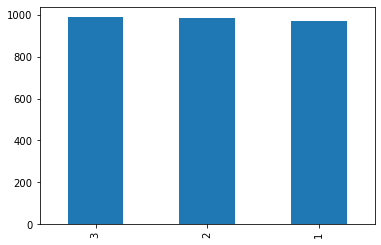

In [165]:
print (color.BOLD, color.UNDERLINE, color.BLUE,"It can be seen that the amount of the different positions of the hands are balanced:",
      color.END)
df['state'].value_counts().plot.bar()

In [301]:
y_valid = df_valid['state']
X_valid = df_valid.drop("state",axis=1)

X_valid.shape

(402, 180)

In [302]:
y_train = df['state']
X_train = df.drop("state",axis=1)

X_train.shape

(2939, 180)

* ### We will now look at the effect of PCA on understanding data in order to know how much to reduce the data:

(2939, 180)

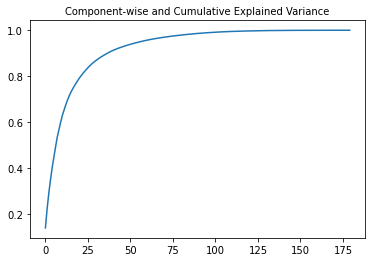

In [328]:
#First we have to normalize features:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)

pca = PCA(n_components = 180, random_state=42)
X_reduced_180 = pca.fit_transform(X_train_sc)


#Plot Component-wise and Cumulative Explained Variance:
plt.subplot(1, 1, 1)
plt.plot(range(180), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance", fontsize=10)


X_reduced_180.shape

* ### As we can see even in only 50 dimensions we get a pretty good understanding of the data, we will use this information later when we want to reduce the data

# Training a model


In [169]:
# Creates list for the following graphs:
retained_variance = np.linspace(0.65, 1, num=8)
num_components = []
for RV in retained_variance:
    if RV == 1:  # take all the components
        num_components.append(180)
    else:
        pca = PCA(n_components = RV, random_state=42)
        X_reduced = pca.fit_transform(X_train_sc)
        num_components.append(X_reduced.shape[1])

### Logistic Regression
* #### We now want to understand whether or not the reduction of the dimension help to get a better model
* #### So let's try Logistic Regression PCA with a retained variance of between 0.65 and 1 (meaning, without PCA)

In [170]:
#---------------Logistic Regression with PCA-----------------------
retained_variance = np.linspace(0.65, 1, num=8)
accuracy_LG = []

for RV in retained_variance:
    if RV == 1:  # take all the components
        pipe_LG_PCA = Pipeline([
        ("scale", StandardScaler()),
        ('lg_clf', LogisticRegression(multi_class='ovr',max_iter=100000))
        ])
    else:
        pipe_LG_PCA = Pipeline([
             ("pca", PCA(n_components=RV, random_state=42)),
            ("scale", StandardScaler()),
            ('lg_clf', LogisticRegression(multi_class='ovr',max_iter=100000))
        ])

    pipe_LG_PCA.fit(X_train, y_train)
    y_pred_LG_PCA = pipe_LG_PCA.predict(X_valid)
    
    #save the accuracy
    accuracy = accuracy_score(y_valid, y_pred_LG_PCA)
    accuracy_LG.append(accuracy)

Text(0.5, 1.0, 'The number of dimensions in relation to the accuracy we obtained on Logistic Regression')

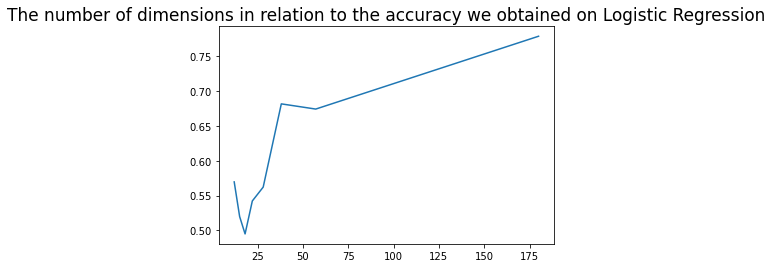

In [171]:
ax = plt.axes()
ax.plot(num_components, accuracy_LG)
plt.title("The number of dimensions in relation to the accuracy we obtained on Logistic Regression", fontsize=17, fontweight=100)

* ### It can be seen that the best model is achieved with the help of all the data (180 dimensions).
* ### In addition, it can be seen that the decrease in accuracy is almost linear.

In [174]:
print(color.BOLD, color.UNDERLINE,'We will now look in detail at the results of the model that uses all the data:',
     color.END)
print(classification_report(y_valid, y_pred_LG_PCA,
                                digits=4, target_names=classes))

print(color.BOLD, color.UNDERLINE,'It can be seen that the situation "Alone" is the easiest to identify',
     color.END)

  We will now look in detail at the results of the model that uses all the data: 
              precision    recall  f1-score   support

       Alone     0.9496    1.0000    0.9742       132
     Spontan     0.7273    0.5373    0.6180       134
        Sync     0.6646    0.8015    0.7267       136

    accuracy                         0.7786       402
   macro avg     0.7805    0.7796    0.7730       402
weighted avg     0.7791    0.7786    0.7717       402

  It can be seen that the situation "Alone" is the easiest to identify 


* ### Although without PCA the model would be less compact I think that from the data we have presented here it is clear that all dimensions have meaning in understanding the data (the decrease in accuracy is almost linear depending on the amount of dimensions)
* ### Therefore I choose to use a model without PCA or at most a reduction to a retained variance of 0.95

### Random Forest Classifier

In [175]:
#---------------Random Forest Classifier with PCA-----------------------
retained_variance = np.linspace(0.65, 1, num=8)
accuracy_RF = []

for RV in retained_variance:
    if RV == 1:  # take all the components
        pipe_RF_PCA = Pipeline([
        ("scale", StandardScaler()),
        ('rf_clf', RandomForestClassifier())
        ])
    else:
        pipe_RF_PCA = Pipeline([
             ("pca", PCA(n_components=RV, random_state=42)),
            ("scale", StandardScaler()),
            ('rf_clf', RandomForestClassifier())
        ])

    pipe_RF_PCA.fit(X_train, y_train)
    y_pred_RF_PCA = pipe_RF_PCA.predict(X_valid)
    
    #save the accuracy
    accuracy = accuracy_score(y_valid, y_pred_RF_PCA)
    accuracy_RF.append(accuracy)

Text(0.5, 1.0, 'The number of dimensions in relation to the accuracy we obtained on Random Forest classifier')

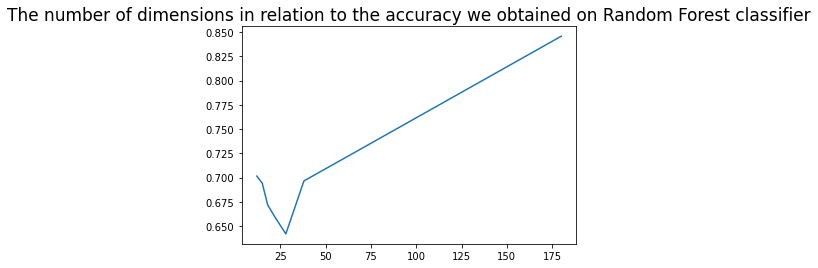

In [177]:
ax = plt.axes()
ax.plot(num_components, accuracy_RF)
plt.title("The number of dimensions in relation to the accuracy we obtained on Random Forest classifier", fontsize=17, fontweight=100)

* ### Here too it can be seen that it is will be better not to perform a PCA and use all the data

# xgboost classifier
* ### We will now look for the best parameters for xgboost classifier
* ### The parameters I will focus on:
    * #### max_depth - Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 
    * #### n_estimators - Number of gradient boosted trees. Equivalent to number of boosting rounds.
    * #### n_components (of the PCA) - Number of components to keep.

In [60]:
import warnings
warnings.filterwarnings("ignore")

In [184]:
# # Todo:  fix the overfiting


# #---------------xgboost classifier with PCA-----------------------
# pipe_xgb_PCA = Pipeline([
# #     ("pca", PCA(n_components=0.99999, random_state=42)),
#     ("scale", StandardScaler()),
#     ('xgb', XGBClassifier(learning_rate = 0.2, n_estimators=64, seed=0, eval_metric='mlogloss'))
# ])

# pipe_xgb_PCA.fit(X_train, y_train)
# y_pred_xgb_PCA = pipe_xgb_PCA.predict(X_valid)

# #save the accuracy
# accuracy = accuracy_score(y_valid, y_pred_xgb_PCA)
# accuracy

0.8308457711442786

In [181]:
# # Todo:  fix the overfiting


# #---------------xgboost classifier with PCA-----------------------
# pipe_xgb_PCA = Pipeline([
# #     ("pca", PCA(n_components=0.99999, random_state=42)),
#     ("scale", StandardScaler()),
#     ('xgb', XGBClassifier(n_estimators=64, seed=0, eval_metric='mlogloss'))
# ])

# pipe_xgb_PCA.fit(X_train, y_train)
# y_pred_xgb_PCA = pipe_xgb_PCA.predict(X_valid)

# #save the accuracy
# accuracy = accuracy_score(y_valid, y_pred_xgb_PCA)
# accuracy

0.845771144278607

In [185]:
#---------------xgboost classifier with PCA-----------------------
retained_variance = np.linspace(50, 70, num=20)
accuracy_xgb = []

for n in retained_variance:
    n = int(n)
    pipe_xgb_PCA = Pipeline([
        ("scale", StandardScaler()),
        ('xgb', XGBClassifier(learning_rate = 0.2, n_estimators=n, seed=0, eval_metric='mlogloss'))
    ])

    pipe_xgb_PCA.fit(X_train, y_train)
    y_pred_xgb_PCA = pipe_xgb_PCA.predict(X_valid)

    #save the accuracy
    accuracy = accuracy_score(y_valid,y_pred_xgb_PCA)
    accuracy_xgb.append(accuracy)

Text(0.5, 1.0, "The number of 'n_estimators' in relation to the accuracy we obtained on xgboost classifier")

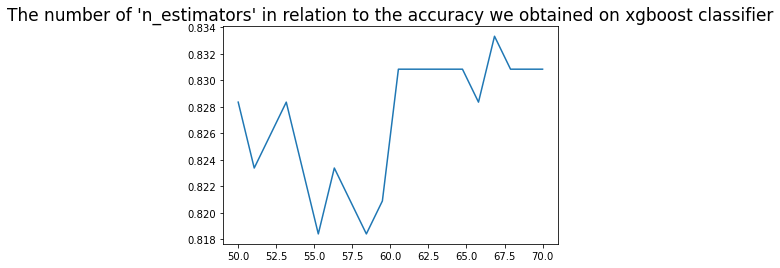

In [190]:
ax = plt.axes()
ax.plot(np.linspace(50, 70, num=20), accuracy_xgb)
plt.title("The number of 'n_estimators' in relation to the accuracy we obtained on xgboost classifier", fontsize=17, fontweight=100)

* ### As we can see n = 67 This is the ideal n_estimators -> its accuracy = 0.8333333333333334

In [206]:
#---------------xgboost classifier with PCA-----------------------
max_depth = [1,2,3,4,6,8]
accuracy_xgb = []

for n in max_depth:
    pipe_xgb_PCA = Pipeline([
        ("scale", StandardScaler()),
        ('xgb', XGBClassifier(learning_rate = 0.2, n_estimators=67, max_depth=n, seed=0, eval_metric='mlogloss'))
    ])

    pipe_xgb_PCA.fit(X_train, y_train)
    y_pred_xgb_PCA = pipe_xgb_PCA.predict(X_valid)

    #save the accuracy
    accuracy = accuracy_score(y_valid,y_pred_xgb_PCA)
    accuracy_xgb.append(accuracy)

Text(0.5, 1.0, "The number of 'max_depth' in relation to the accuracy we obtained on xgboost classifier")

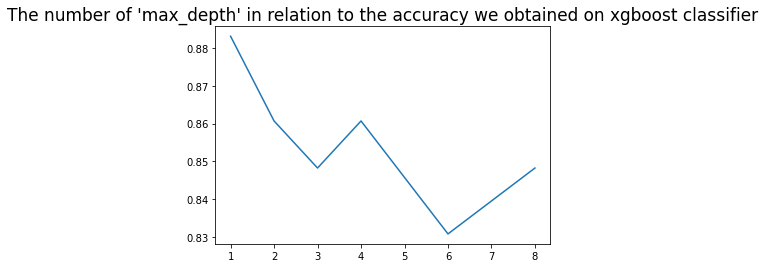

In [207]:
ax = plt.axes()
ax.plot(max_depth, accuracy_xgb)
plt.title("The number of 'max_depth' in relation to the accuracy we obtained on xgboost classifier", fontsize=17, fontweight=100)

* ### As we can see n = 1 This is the ideal max_depth -> its accuracy = 0.8830845771144279

In [210]:
#---------------xgboost classifier with PCA-----------------------
retained_variance = np.linspace(0.65, 1, num=8)
accuracy_xgb = []

for RV in retained_variance:
    if RV == 1:  # take all the components
        pipe_xgb_PCA = Pipeline([
        ("scale", StandardScaler()),
        ('xgb', XGBClassifier(learning_rate = 0.2, n_estimators=67, max_depth=1, seed=0, eval_metric='mlogloss'))
        ])
    else:
        pipe_xgb_PCA = Pipeline([
             ("pca", PCA(n_components=RV, random_state=42)),
            ("scale", StandardScaler()),
            ('xgb', XGBClassifier(learning_rate = 0.2, n_estimators=67, max_depth=1, seed=0, eval_metric='mlogloss'))
        ])

    pipe_xgb_PCA.fit(X_train, y_train)
    y_pred_xgb_PCA = pipe_xgb_PCA.predict(X_valid)

    #save the accuracy
    accuracy = accuracy_score(y_valid,y_pred_xgb_PCA)
    accuracy_xgb.append(accuracy)

Text(0.5, 1.0, 'The number of dimensions in relation to the accuracy we obtained on xgboost classifier')

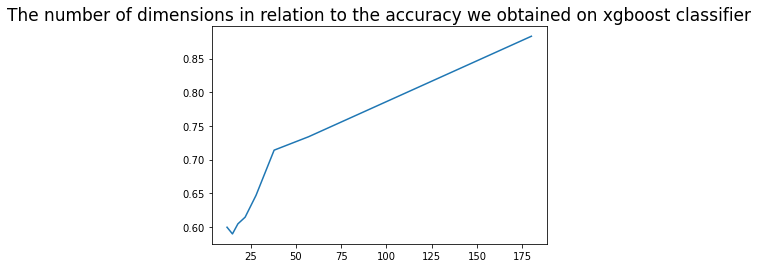

In [212]:
ax = plt.axes()
ax.plot(num_components, accuracy_xgb)
plt.title("The number of dimensions in relation to the accuracy we obtained on xgboost classifier", fontsize=17, fontweight=100)

* ### Here too it can be seen that it is will be better not to perform a PCA and use all the data, and if we do PCA it will be a very small reduction


### K-Neighbors Classifier 
* #### We will now find the ideal 'n' for 'n_neighbors'

In [213]:
#---------------KNN Classifier----------------
accuracy_knn = []

for n in range(1,30):
    pipe_KNN = Pipeline([
        ("scale", StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=n))
    ])

    pipe_KNN.fit(X_train, y_train)
    y_pred_KNN = pipe_KNN.predict(X_valid)
    
    #save the accuracy
    accuracy = accuracy_score(y_valid,y_pred_KNN)
    accuracy_knn.append(accuracy)

Text(0.5, 1.0, "The number of 'n_neighbors' in relation to the accuracy we obtained on KNN classifier")

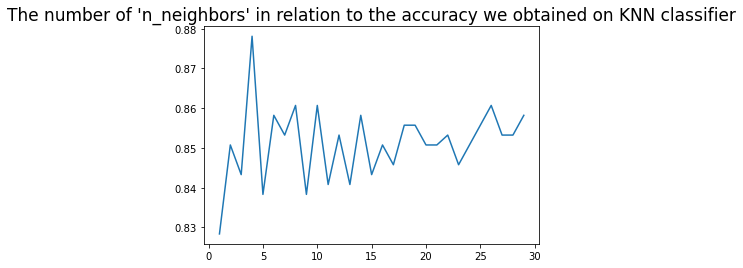

In [214]:
ax = plt.axes()
X = range(1,30)
ax.plot(X, accuracy_knn)
plt.title("The number of 'n_neighbors' in relation to the accuracy we obtained on KNN classifier", fontsize=17, fontweight=100)

* ### It can be seen that the optimal 'n' is n = 4

### Extra Trees Classifier
* ### We will now look for the best parameters for Extra Trees classifier
* ### The parameters I will focus on:
    * #### max_depth - The maximum depth of the tree. 
    * #### n_estimators - The number of trees in the forest.

In [303]:
#---------------Extra Trees Classifier with PCA-----------------------
retained_variance = np.linspace(5, 300, num=80)
accuracy_Ext = []

for n in retained_variance:
    n = int(n)
    pipe_EXT_PCA = Pipeline([
        ("scale", StandardScaler()),
        ('EXT', ExtraTreesClassifier(n_estimators=n))
    ])

    pipe_EXT_PCA.fit(X_train, y_train)
    y_pred_EXT_PCA = pipe_EXT_PCA.predict(X_valid)

    #save the accuracy
    accuracy = accuracy_score(y_valid,y_pred_EXT_PCA)
    accuracy_Ext.append(accuracy)

Text(0.5, 1.0, "The number of 'n_estimators' in relation to the accuracy we obtained on Extra Trees classifier")

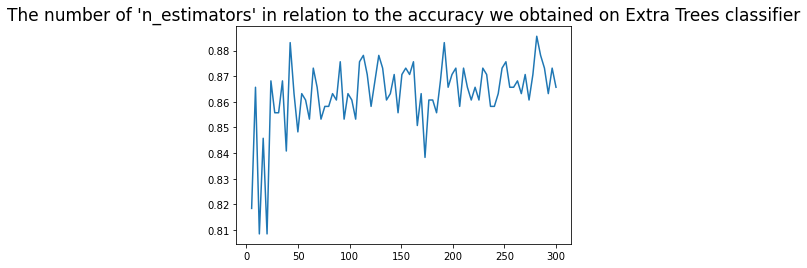

In [304]:
ax = plt.axes()
ax.plot(np.linspace(5, 300, num=80), accuracy_Ext)
plt.title("The number of 'n_estimators' in relation to the accuracy we obtained on Extra Trees classifier", fontsize=17, fontweight=100)

* ### The best n for 'n_estimators' is n = 200

In [310]:
#---------------Extra Trees classifier with PCA-----------------------
max_depth = [2,3,4,6,7,8,10,12]
accuracy_Ext = []

for n in max_depth:
    pipe_EXT = Pipeline([
        ("scale", StandardScaler()),
        ('EXT', ExtraTreesClassifier(n_estimators=200, max_depth=n, random_state=42))
    ])

    pipe_EXT.fit(X_train, y_train)
    y_pred_EXT = pipe_EXT.predict(X_valid)

    #save the accuracy
    accuracy = accuracy_score(y_valid,y_pred_EXT)
    accuracy_Ext.append(accuracy)

Text(0.5, 1.0, "The number of 'max_depth' in relation to the accuracy we obtained on Extra Trees classifier")

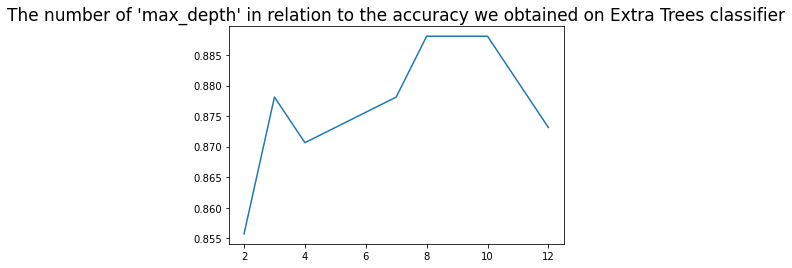

In [312]:
ax = plt.axes()
ax.plot(max_depth, accuracy_Ext)
plt.title("The number of 'max_depth' in relation to the accuracy we obtained on Extra Trees classifier", fontsize=17, fontweight=100)

* ### As we can see n = 8 This is the ideal max_depth -> its accuracy = 0.8880597014925373

### We will now try to create an ensemble model that will contain the models we have seen so far in the best way:

# Voting Classifier

In [318]:
#---------------Voting Classifier with PCA-----------------------
retained_variance = np.linspace(0.80, 1, num=40)
accuracy_VOT = []

for RV in retained_variance:
    if RV == 1:  # take all the components
        pipe_VOT = Pipeline([
                    ("scale", StandardScaler()),
                    ('voting_clf', VotingClassifier(
                                estimators=[
                        ('lg', LogisticRegression(multi_class='ovr',max_iter=100000)),
                        ('rf', RandomForestClassifier()),
                        ('knn', KNeighborsClassifier(n_neighbors=4)),
                        ('EXT', ExtraTreesClassifier(n_estimators=200, max_depth=8, random_state=42)),
                        ('xgb', XGBClassifier(learning_rate = 0.2, n_estimators=67, max_depth=1, seed=0, eval_metric='mlogloss'))
            ], voting='soft'))
])

    else:
        pipe_VOT = Pipeline([
                    ("scale", StandardScaler()),
                    ("pca", PCA(n_components=RV, random_state=42)),
                    ('voting_clf', VotingClassifier(
                                estimators=[
                        ('lg', LogisticRegression(multi_class='ovr',max_iter=100000)),
                        ('rf', RandomForestClassifier()),
                        ('knn', KNeighborsClassifier(n_neighbors=4)),
                        ('EXT', ExtraTreesClassifier(n_estimators=200, max_depth=8, random_state=42)),
                        ('xgb', XGBClassifier(learning_rate = 0.2, n_estimators=67, max_depth=1, seed=0, eval_metric='mlogloss'))
            ], voting='soft'))
])


    pipe_VOT.fit(X_train, y_train)
    y_pred_VOT_PCA = pipe_VOT.predict(X_valid)
    
    #save the accuracy
    accuracy = accuracy_score(y_valid,y_pred_VOT_PCA)    
    accuracy_VOT.append(accuracy)

In [319]:
num_components_vot = []
for RV in retained_variance:
    if RV == 1:  # take all the components
        num_components_vot.append(180)
    else:
        pca = PCA(n_components = RV, random_state=42)
        X_reduced = pca.fit_transform(X_train_sc)
        num_components_vot.append(X_reduced.shape[1])

Text(0.5, 1.0, 'The number of dimensions in relation to the accuracy we obtained on Voting classifier')

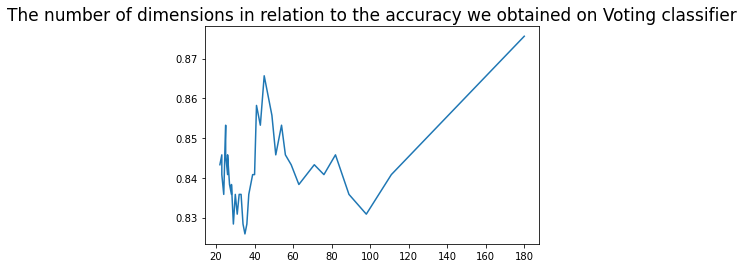

In [320]:
ax = plt.axes()
ax.plot(num_components_vot, accuracy_VOT)
plt.title("The number of dimensions in relation to the accuracy we obtained on Voting classifier", fontsize=17, fontweight=100)

* ### Surprisingly we see that ostensibly if we take a PCA with 50 dimensions we will get a less good result only as a percentage of a model that uses all the data.
* ### With PCA of 45 dimensions (0.923 of retained_variance) we get 0.8656716417910447 and on the model wuthout PCA we get 0.8756218905472637. 
* ### We will take this figure in proportion because it is surprising and different from what we have seen so far.

### Dummy Classifier
* #### Each model must be at least better than Dummy Classifier to be considered a good model

In [458]:
#-------- Dummy Classifier -------
pipe_dm = Pipeline([
    ("scale", StandardScaler()),
    ('dm', DummyClassifier(strategy = 'stratified'))
])

y_pred_dm = cross_val_predict(pipe_dm, X_train, y_train)

print(classification_report(y_train, y_pred_dm,
                                digits=4, target_names=classes))

#save the accuracy
accuracy_dm = accuracy_score(y_train,y_pred_dm)

              precision    recall  f1-score   support

       Alone     0.3512    0.3506    0.3509      1101
     Spontan     0.3420    0.3411    0.3416      1117
        Sync     0.3369    0.3384    0.3376      1123

    accuracy                         0.3433      3341
   macro avg     0.3434    0.3434    0.3434      3341
weighted avg     0.3433    0.3433    0.3433      3341



* ### As we can see all the models are better than the Dummy Classifier

# Final Results - Comparing the best models

<function matplotlib.pyplot.show(*args, **kw)>

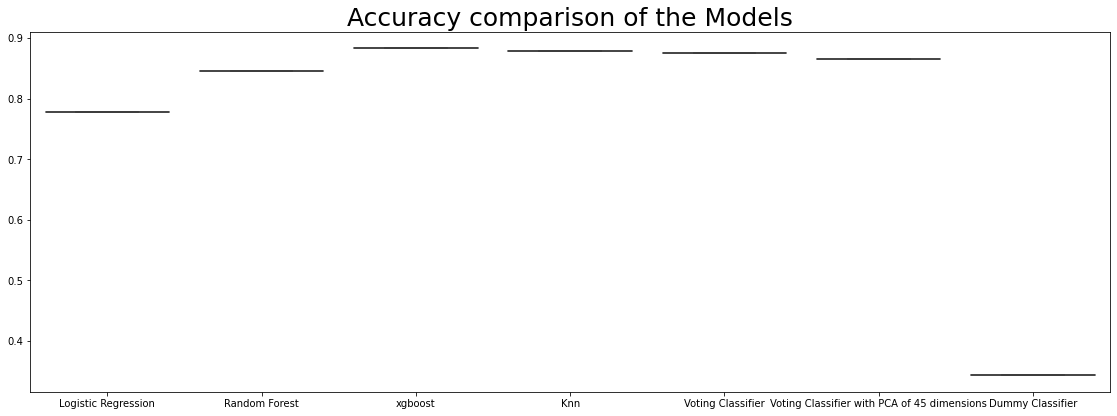

In [459]:
Models = ["Logistic Regression", "Random Forest", "xgboost", "Knn", "Voting Classifier", "Voting Classifier with PCA of 45 dimensions", "Dummy Classifier"]
Accuracy = [0.7786,  0.845771144278607, 0.8830845771144279, 0.8781094527363185,  0.8756218905472637, 0.8656716417910447, 0.3433]

fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
x = Models
y = Accuracy
sns.boxplot(x=x, y=y)
plt.title("Accuracy comparison of the Models",fontsize=25)
plt.show

## In conclusion:
* ## Since our task was to build a model that is as accurate but also as compact as possible, I will choose the Voting Classifier with PCA of 45 dimensions.
* ## In addition, it is an ensemble model and therefore it is more reliable and 'stronger' compared to a non-ensemble model (Knn, for example)

# Test the model:

* ### First, as we said earlier, we will connect the data train and data validation to one big data in order to train the model we have chosen, with as much data as possible:

In [338]:
df = pd.concat([df,df_valid])
df = shuffle(df)
df = df.reset_index(drop=True)
df.shape

(3341, 181)

In [339]:
y_train = df['state']
X_train = df.drop("state",axis=1)

X_train.shape

(3341, 180)

* ### Loading data test:

In [266]:
first = True
for name in names_test:
    person_path = os.path.join(test_dir, name)
    df_person = Loading_dataset(person_path)
    if first:
        df_test = df_person
        first = False
    else:
        df_test = pd.concat([df_test,df_person])
df_test = shuffle(df_test)
df_test = df_test.reset_index(drop=True)
df_test

,Position X_L_0,Position Y_L_0,Position Z_L_0,Velocity X_L_0,Velocity Y_L_0,Velocity Z_L_0,Pitch_L_0,Roll_L_0,Yaw_L_0,Wrist Pos X_L_0,...,Wrist Pos X_R_4,Wrist Pos Y_R_4,Wrist Pos Z_R_4,Elbow pos X_R_4,Elbow Pos Y_R_4,Elbow Pos Z_R_4,Grab Strenth_R_4,Grab Angle_R_4,Pinch Strength_R_4,state
0,-108.22440,207.9178,97.711720,-0.071515,165.57220,107.16460,1.500600,1.185726,1.407507,-141.71500,...,194.31120,145.7368,78.45564,354.4719,-59.273540,117.95830,0.0,0.000000,0.0,3
1,-34.26217,150.6897,38.006430,231.413200,-71.82932,-48.41824,0.653065,0.241075,1.345737,-100.52710,...,54.62966,242.4959,40.14814,234.7267,140.040500,212.35020,0.0,0.117282,0.0,1
2,-125.20780,270.5536,47.800470,8.400753,106.33170,52.77100,1.359199,1.014568,1.144544,-163.36110,...,163.58450,191.9363,75.88947,315.7319,-21.508670,52.07822,0.0,0.000000,0.0,3
3,-125.44390,174.6315,-23.618820,48.267310,-23.51253,-14.95533,0.647395,2.275146,0.979543,-178.52470,...,185.93130,131.2952,15.74748,382.4771,83.556860,160.36900,0.0,0.578732,0.0,2
4,-95.18724,223.6784,94.598960,-111.904300,159.17220,43.15387,1.611182,0.939033,1.636137,-128.16440,...,207.52550,180.4247,28.25300,293.4394,-29.166640,115.81680,0.0,0.202259,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,-124.21680,199.9627,6.373457,136.973700,-52.05759,-29.78218,0.660997,0.570373,0.522963,-163.78580,...,210.80610,154.2538,131.87420,385.6276,-40.320300,134.20460,0.0,0.240510,0.0,2
1585,-130.64990,242.9051,25.303710,-2.703259,35.78471,-98.46572,0.540791,1.990464,0.418228,-159.47640,...,30.20442,226.1618,81.06244,204.9797,147.096600,230.33240,0.0,0.000000,0.0,3
1586,-143.93240,277.8022,107.275300,-160.728900,31.95984,-41.87959,2.313693,0.251958,1.834842,-204.94690,...,23.73484,170.6067,46.25003,132.0223,-3.564826,224.90820,0.0,0.372123,0.0,1
1587,-46.83142,150.2017,-8.541468,13.708260,83.73742,46.03798,0.620242,2.032865,0.526681,-81.78284,...,181.32620,157.6354,77.75506,372.0177,0.724145,109.95850,0.0,0.000000,0.0,3


In [268]:
y_test = df_test['state']
X_test = df_test.drop("state",axis=1)

X_test.shape

(1589, 180)

In [340]:
X_test

,Position X_L_0,Position Y_L_0,Position Z_L_0,Velocity X_L_0,Velocity Y_L_0,Velocity Z_L_0,Pitch_L_0,Roll_L_0,Yaw_L_0,Wrist Pos X_L_0,...,Yaw_R_4,Wrist Pos X_R_4,Wrist Pos Y_R_4,Wrist Pos Z_R_4,Elbow pos X_R_4,Elbow Pos Y_R_4,Elbow Pos Z_R_4,Grab Strenth_R_4,Grab Angle_R_4,Pinch Strength_R_4
0,-108.22440,207.9178,97.711720,-0.071515,165.57220,107.16460,1.500600,1.185726,1.407507,-141.71500,...,-1.272094,194.31120,145.7368,78.45564,354.4719,-59.273540,117.95830,0.0,0.000000,0.0
1,-34.26217,150.6897,38.006430,231.413200,-71.82932,-48.41824,0.653065,0.241075,1.345737,-100.52710,...,-0.794178,54.62966,242.4959,40.14814,234.7267,140.040500,212.35020,0.0,0.117282,0.0
2,-125.20780,270.5536,47.800470,8.400753,106.33170,52.77100,1.359199,1.014568,1.144544,-163.36110,...,-1.923752,163.58450,191.9363,75.88947,315.7319,-21.508670,52.07822,0.0,0.000000,0.0
3,-125.44390,174.6315,-23.618820,48.267310,-23.51253,-14.95533,0.647395,2.275146,0.979543,-178.52470,...,-1.704096,185.93130,131.2952,15.74748,382.4771,83.556860,160.36900,0.0,0.578732,0.0
4,-95.18724,223.6784,94.598960,-111.904300,159.17220,43.15387,1.611182,0.939033,1.636137,-128.16440,...,-0.710023,207.52550,180.4247,28.25300,293.4394,-29.166640,115.81680,0.0,0.202259,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,-124.21680,199.9627,6.373457,136.973700,-52.05759,-29.78218,0.660997,0.570373,0.522963,-163.78580,...,-1.416415,210.80610,154.2538,131.87420,385.6276,-40.320300,134.20460,0.0,0.240510,0.0
1585,-130.64990,242.9051,25.303710,-2.703259,35.78471,-98.46572,0.540791,1.990464,0.418228,-159.47640,...,-0.173669,30.20442,226.1618,81.06244,204.9797,147.096600,230.33240,0.0,0.000000,0.0
1586,-143.93240,277.8022,107.275300,-160.728900,31.95984,-41.87959,2.313693,0.251958,1.834842,-204.94690,...,-0.163275,23.73484,170.6067,46.25003,132.0223,-3.564826,224.90820,0.0,0.372123,0.0
1587,-46.83142,150.2017,-8.541468,13.708260,83.73742,46.03798,0.620242,2.032865,0.526681,-81.78284,...,-1.104975,181.32620,157.6354,77.75506,372.0177,0.724145,109.95850,0.0,0.000000,0.0


In [400]:
pipe_VOT = Pipeline([
                    ("scale", StandardScaler()),
                    ("pca", PCA(n_components=45, random_state=42)),
                    ('voting_clf', VotingClassifier(
                                estimators=[
                        ('lg', LogisticRegression(multi_class='ovr',max_iter=100000)),
                        ('rf', RandomForestClassifier()),
                        ('knn', KNeighborsClassifier(n_neighbors=4)),
                        ('EXT', ExtraTreesClassifier(n_estimators=200, max_depth=8, random_state=42)),
                        ('xgb', XGBClassifier(learning_rate = 0.2, n_estimators=67, max_depth=1, seed=0, eval_metric='mlogloss'))
            ], voting='soft'))
])

pipe_VOT.fit(X_train, y_train)
y_pred_VOT_final = pipe_VOT.predict(X_test)

print(classification_report(y_test, y_pred_VOT_final,
                                digits=4, target_names=classes))

#save the accuracy
final_accuracy = accuracy_score(y_test,y_pred_VOT_final)   
final_accuracy

              precision    recall  f1-score   support

       Alone     0.9907    1.0000    0.9953       531
     Spontan     0.7749    0.9679    0.8607       530
        Sync     0.9591    0.7102    0.8161       528

    accuracy                         0.8930      1589
   macro avg     0.9082    0.8927    0.8907      1589
weighted avg     0.9082    0.8930    0.8909      1589



0.8930144745122719

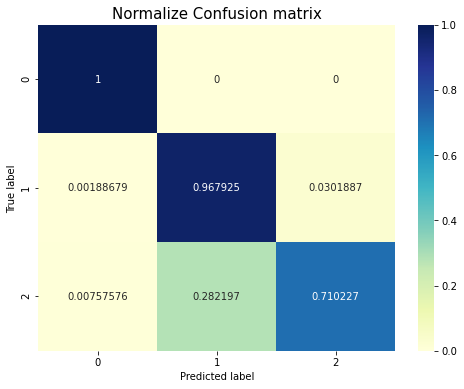

In [460]:
#----------------------Normalize Confusion matrix------------------------------------
from sklearn.metrics import plot_confusion_matrix

con_mat = confusion_matrix(y_test, y_pred_VOT_final,normalize='true')
f, ax = plt.subplots(figsize=(8, 6))
plt.title('Normalize Confusion matrix', size = 15)
sns.heatmap(con_mat, annot=True, fmt='g',cmap="YlGnBu")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

* ### Alone = 1
* ### Spontan = 2
* ### Sync = 3

# In conclusion, we got a Voting Classifier model that we were able to reduce its dimensions from 180 to 45 dimensions (!) and reach an accuracy of - 89.30%